From https://github.com/nicoleeesim/content-based_movie_recommender

# Building a simple Content-Based Recommender System for Netflix Movies and TV Shows

### Objective
With over 6000 movie and tv shows in a sample dataset, there is an overwhelming number of entertainment options available to Netflix users. As such, the purpose of this project aims to make a TV show / movie recommendation using a simple content based recommender system. We would take in an input which is a user's personal favourite show/movies and pick up the top 10 films that are most similar to the personal favourite. Here, we explore 2 possible ways to identify similar items: (1) a simple similarity measure - Cosine Similarity (2) Clustering Algorithm - Latent Dirichlet Allocation (LDA).

### Basics on Recommender System
Recommender Systems can be generally divided into 2 categories: Collaborative Filtering System and Content-based Recommender System. A Collaborative Filtering recommends an item that other users of similar characteristics have liked in the past. A content-based recommender system recommends an item which are similar to the ones the user has liked in the past. Since the given dataset only contains item data, we would focus on creating a basic content-based recommender system. 

### Basics on Text Similarity

There are various text similarity metrics and one of the popular metrics is Cosine Similarity. 
Consine Similarity measures the similarity between 2 documents by measuring the consine of angle between two vectors. Here's a simple example to illustrate the calculation of cosine similarity:



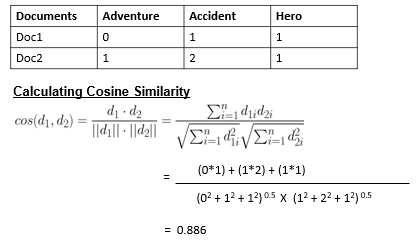

### Basics on Topic Modelling
Topic Modelling is an unsupervised learning technique which groups documents based on the content similarity. One popular algorithm is Latent Dirichlet Allocation (LDA). In LDA, each topic is a probability distribution of words and each document is a probability distribution of topics. The more similar the documents are, the closer they are to each other in the multi-dimensional vector space, thus forming clusters. 




### References
https://www.cse.iitk.ac.in/users/nsrivast/HCC/Recommender_systems_handbook.pdf

https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


### 1. Cosine Similarity

Cosine similarity is computed based on the features - 'title', 'type', 'listed_in', 'director', 'cast', 'rating' and 'description'.

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv("./data/netflix_titles.csv")
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


#### 1.1 Data Pre-Processing

In [4]:
cols = ['title', 'type', 'listed_in', 'director', 'cast', 'rating', 'description']
df['combined'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# remove non-english words. Reference: https://datascience.stackexchange.com/questions/46705/to-remove-chinese-characters-as-features
df['combined'] = df['combined'].map(lambda x: re.sub("([^\x00-\x7F])+","", x))

#### 1.2 Creating Document Vectors

In [5]:
documents = df['combined']

# Create the Document Term Matrix
count_vectorizer = CountVectorizer(stop_words='english') # convert all words to lowercase and remove stop words
sparse_matrix = count_vectorizer.fit_transform(documents)

# Convert Sparse Matrix to Pandas Dataframe 
doc_term_matrix = sparse_matrix.todense()
matrix_df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), index=df.index)


/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### 1.3 Computing Cosine Similarity between each document

In [43]:
similarity_scores = cosine_similarity(sparse_matrix, sparse_matrix) 

scores_df = pd.DataFrame(similarity_scores )
scores_df

,0,1,2,3,4,5,6,7,8,9,...,6224,6225,6226,6227,6228,6229,6230,6231,6232,6233
0,1.000000,0.049507,0.080016,0.063330,0.081701,0.102643,0.064062,0.062622,0.072044,0.065606,...,0.067267,0.121268,0.118002,0.101057,0.079388,0.105021,0.076222,0.073127,0.118866,0.141479
1,0.049507,1.000000,0.126269,0.133250,0.051571,0.151177,0.026958,0.237171,0.181902,0.027608,...,0.084921,0.127578,0.127688,0.153093,0.167038,0.110485,0.120281,0.123091,0.150061,0.127578
2,0.080016,0.126269,1.000000,0.409194,0.104189,0.279244,0.021786,0.063888,0.293998,0.044621,...,0.160128,0.268055,0.275168,0.309295,0.296972,0.232143,0.233285,0.074605,0.277184,0.268055
3,0.063330,0.133250,0.409194,1.000000,0.087960,0.294684,0.000000,0.067420,0.310253,0.000000,...,0.168982,0.282876,0.290382,0.326396,0.313392,0.244978,0.205152,0.078730,0.292509,0.282876
4,0.081701,0.051571,0.104189,0.087960,1.000000,0.089101,0.022244,0.043489,0.075047,0.068341,...,0.046714,0.126323,0.122921,0.105269,0.082698,0.091166,0.079399,0.025392,0.106132,0.126323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,0.105021,0.110485,0.232143,0.244978,0.091166,0.335966,0.057187,0.074536,0.321560,0.039043,...,0.180144,0.342802,0.331061,0.324760,0.307096,1.000000,0.238145,0.065279,0.348645,0.360844
6230,0.076222,0.120281,0.233285,0.205152,0.079399,0.282628,0.020752,0.081144,0.280056,0.000000,...,0.152535,0.294628,0.278501,0.274986,0.257172,0.238145,1.000000,0.071067,0.297044,0.274986
6231,0.073127,0.123091,0.074605,0.078730,0.025392,0.063801,0.053093,0.025950,0.179124,0.027186,...,0.111499,0.075378,0.083826,0.075378,0.098693,0.065279,0.071067,1.000000,0.063330,0.100504
6232,0.118866,0.150061,0.277184,0.292509,0.106132,0.474087,0.018493,0.126543,0.374351,0.000000,...,0.213602,0.385077,0.423369,0.402581,0.389597,0.348645,0.297044,0.063330,1.000000,0.385077


#### 1.4 Top 10 recommended tv shows/movies based on Cosine Similarity

In [44]:
def recommend(title,scores_df, df):
    recommended = []
    
    # getting title's index 
    title = title.lower()
    df['title'] = df['title'].str.lower()
    index = df[df['title']==title].index[0]
    
    top10_list = list(scores_df.iloc[index].sort_values(ascending = False).iloc[1:11].index)
    
    
    for each in top10_list:
        recommended.append(df.iloc[each].title)
    
    return recommended
    
    

In [45]:
recommend('Avengers: Infinity War',scores_df, df)

['thor: ragnarok',
 "cirque du freak: the vampire's assistant",
 'limitless',
 'inception',
 'chris brown: welcome to my life',
 'hulk vs.',
 'takers',
 'her',
 'star wars: episode viii: the last jedi',
 'scorpion king 5: book of souls']

In [46]:
recommend('Naruto Shippuden : Blood Prison',scores_df, df)

['naruto shippuden: the movie',
 'naruto shippûden the movie: bonds',
 'naruto shippuden: the movie: the lost tower',
 'naruto shippûden the movie: the will of fire',
 'naruto',
 'naruto the movie 2: legend of the stone of gelel',
 'naruto the movie 3: guardians of the crescent moon kingdom',
 'naruto the movie: ninja clash in the land of snow',
 'berserk: the golden age arc iii - the advent',
 'id-0']

### 2. Topic Modelling with LDA

I have chosen to explore the use of LDA on the 'description' textual data to detect similar documents because I speculate that there might be previously unknown underlying topics in the movie/tv shows' storyline which differs from the typical genre classification such as Adventure, Romance.  

In [6]:
# Importing modules
import pandas as pd
import re

# LDA Model
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy

# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

#plotting libraries!
import matplotlib.pyplot as plt
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

In [7]:
df = pd.read_csv("./data/netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


#### 2.1 Data Pre-Processing

In [8]:
# remove non-english words. Reference: https://datascience.stackexchange.com/questions/46705/to-remove-chinese-characters-as-features
df['description'] = df['description'].map(lambda x: re.sub("([^\x00-\x7F])+","", x))

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(df['description']))

# print(data_words)

In [10]:
stop_words = stopwords.words('english')
# stop_words.extend(['']) #extend existing stop word list if needed
# print(stop_words)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [11]:
# Build the bigram 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [12]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['near', 'end', 'life', 'filmmaker', 'kirsten', 'death', 'inventive', 'comical', 'way', 'help', 'face', 'inevitable']]


#### 2.2 EDA

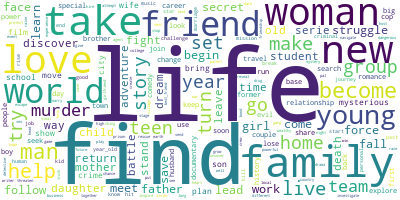

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud
import itertools

# Join the different processed titles together
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
long_string

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)

# # Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:10])
# print(id2word[:10])

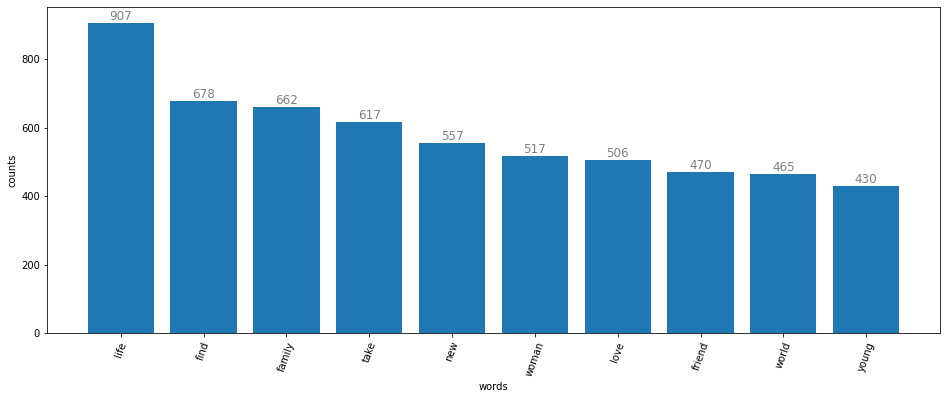

In [17]:
import operator


word_freq = []
word_list = []
count_dict = {}
for n in id2word.values():
    count_dict[n] = list_of_words.count(n)
sorted_dict = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)[0:10]

plt.figure(figsize=(16,6))
plt.bar(range(len(sorted_dict)), [val[1] for val in sorted_dict], align='center')
plt.xticks(range(len(sorted_dict)), [val[0] for val in sorted_dict])
plt.xticks(rotation=70)
plt.xlabel('words')
plt.ylabel('counts')

# setting data labels
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='grey', ha='center', va='bottom')
    
plt.show()


#### 2.3 Hyperparameter Tuning for LDA Model

In [18]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"life" + 0.008*"man" + 0.008*"series" + 0.007*"year" + 0.007*"old" + '
  '0.006*"love" + 0.006*"lead" + 0.006*"survive" + 0.006*"explore" + '
  '0.005*"story"'),
 (1,
  '0.009*"team" + 0.007*"win" + 0.007*"player" + 0.007*"film" + '
  '0.006*"girlfriend" + 0.005*"beloved" + 0.005*"agent" + '
  '0.005*"documentary_follow" + 0.005*"go" + 0.005*"save"'),
 (2,
  '0.011*"find" + 0.010*"world" + 0.008*"human" + 0.008*"journey" + '
  '0.007*"become" + 0.006*"discover" + 0.006*"group" + 0.006*"take" + '
  '0.006*"scientist" + 0.005*"teen"'),
 (3,
  '0.017*"life" + 0.016*"new" + 0.012*"make" + 0.010*"world" + 0.009*"family" '
  '+ 0.009*"find" + 0.009*"get" + 0.009*"friend" + 0.009*"boy" + 0.008*"love"'),
 (4,
  '0.010*"life" + 0.009*"woman" + 0.009*"live" + 0.007*"friend" + '
  '0.007*"family" + 0.007*"lead" + 0.007*"find" + 0.007*"hire" + 0.006*"leave" '
  '+ 0.006*"father"'),
 (5,
  '0.013*"murder" + 0.013*"life" + 0.012*"take" + 0.010*"crime" + '
  '0.008*"become" + 0.008*"dea

In [19]:
# Evaluate base model- Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2649029230775325


In [20]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [21]:
# Iterate over possible number of topics. takes about 2-3mins
topic_param = [0,5,10,15,20,25,30,35,40]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

,topic_param,coherence_score
0,0,0.254201
1,5,0.239599
2,10,0.263617
3,15,0.250512
4,20,0.247385
5,25,0.229166
6,30,0.250939
7,35,0.244817
8,40,0.249429


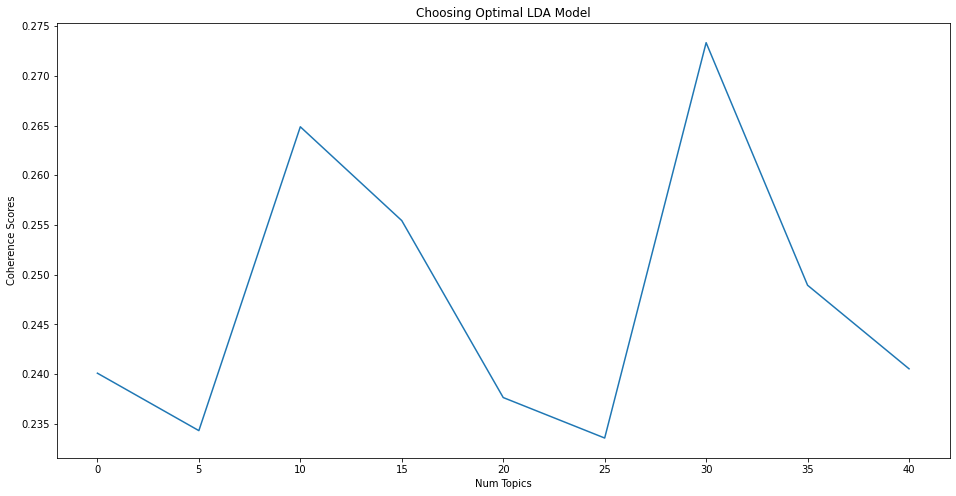

In [23]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()



#### 2.4 Final LDA Model

In [24]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [25]:
# Print the Keyword in the 15 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"life" + 0.007*"adventure" + 0.007*"story" + 0.007*"friend" + '
  '0.005*"series" + 0.005*"take" + 0.004*"fun" + 0.004*"help" + 0.004*"share" '
  '+ 0.004*"world"'),
 (1,
  '0.016*"love" + 0.012*"life" + 0.011*"woman" + 0.009*"find" + 0.009*"family" '
  '+ 0.007*"new" + 0.006*"young" + 0.006*"fall" + 0.006*"man" + 0.006*"get"'),
 (2,
  '0.013*"world" + 0.008*"save" + 0.008*"earth" + 0.006*"evil" + 0.006*"human" '
  '+ 0.004*"team" + 0.004*"planet" + 0.004*"battle" + 0.004*"fight" + '
  '0.004*"scientist"'),
 (3,
  '0.003*"face" + 0.003*"dancer" + 0.002*"well" + 0.002*"train" + 0.002*"take" '
  '+ 0.002*"create" + 0.002*"documentary" + 0.002*"look" + 0.002*"boy" + '
  '0.002*"eye"'),
 (4,
  '0.001*"baby" + 0.001*"presidential" + 0.001*"campaign" + 0.001*"destine" + '
  '0.001*"epic" + 0.001*"discuss" + 0.001*"politic" + 0.001*"sit" + '
  '0.001*"solar" + 0.001*"candidate"'),
 (5,
  '0.007*"life" + 0.005*"friend" + 0.005*"new" + 0.005*"student" + '
  '0.004*"dream" + 0.004*

In [26]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))   

In [35]:
doc_num, topic_num, prob = [], [], []

for n in range(len(df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
df['Doc'] = doc_num
df['Topic'] = topic_num
df['Probability'] = prob
df.to_csv("doc_topic_matrix.csv", index=False)

In [32]:
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,Doc,Topic,Probability
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",0,3,0.493884
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",1,10,0.673348
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2,11,0.990098
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",3,13,0.588280
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,4,5,0.990754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",8802,11,0.988473
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",8803,0,0.982818
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,8804,11,0.987439
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",8805,2,0.515582


#### 2.5 Visualize Topics

In [30]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
LDAvis_prepared

/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/User

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.036644  0.017617       1        1  10.226776
1     -0.130959 -0.076152       2        1  22.729889
2     -0.001820  0.051834       3        1   7.849786
3      0.027066 -0.006042       4        1   2.940876
4      0.048911 -0.006000       5        1   0.479537
5     -0.029747 -0.035810       6        1   6.865628
6      0.052766 -0.010671       7        1   2.471601
7      0.050280 -0.006915       8        1   0.527786
8      0.029476  0.006463       9        1   2.908403
9      0.047424 -0.001541      10        1   1.015920
10    -0.015192 -0.023637      11        1   4.336787
11    -0.148289  0.066304      12        1  30.328037
12     0.048550 -0.005071      13        1   0.440469
13     0.038502  0.004712      14        1   1.222292
14     0.019674  0.024909      15        1   5.656214, topic_info=       Term        Freq       Total Category  logprob  loglift
262    love  387.000000  387.000000  Default  30.0000  30.0000
185   world  284.000000  284.000000  Default  29.0000  29.0000
972   stand   82.000000   82.000000  Default  28.0000  28.0000
562   story  163.000000  163.000000  Default  27.0000  27.0000
145  murder  196.000000  196.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
63    bring   12.317809  115.962339  Topic15  -6.1067   0.6302
142   group   12.002153  176.298866  Topic15  -6.1326   0.1853
26   family   11.895487  493.934963  Topic15  -6.1415  -0.8538
160  follow    9.514667  152.183893  Topic15  -6.3649   0.1002
425    year    9.363369  211.024904  Topic15  -6.3809  -0.2428

[860 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4392      1  0.155589  absurd
4392      2  0.155589  absurd
4392      3  0.155589  absurd
4392      7  0.155589  absurd
4392     12  0.155589  absurd
...     ...       ...     ...
74        4  0.011551   young
74        6  0.049091   young
74       12  0.456257   young
74       14  0.002888   young
74       15  0.025989   young

[4482 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

#### 2.6  Top 10 recommended tv shows/movies based on topic modelling

In [42]:
def recommend_by_storyline(title, df):
    recommended = []
    top10_list = []
    
    title = title.lower()
    df['title'] = df['title'].str.lower()
    topic_num = df[df['title']==title].Topic.values
    doc_num = df[df['title']==title].Doc.values    
    
    output_df = df[df['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)

    index = output_df[output_df['Doc']==doc_num[0]].index[0]
    
    # return the 10 results with closest probability of belonging to topic `topic_num`
    top10_list += list(output_df.iloc[index-5:index].index)
    top10_list += list(output_df.iloc[index+1:index+6].index)
    
    output_df['title'] = output_df['title'].str.title()
    for each in top10_list:
        recommended.append(output_df.iloc[each].title)
        
    return recommended


In [43]:
recommend_by_storyline("Avengers: Infinity War", df)

['Into The Inferno',
 'Afonso Padilha: Classless',
 'Dolphin Kick',
 "What'S New Scooby-Doo?",
 'Long Shot',
 "Michael Bolton'S Big, Sexy Valentine'S Day Special",
 'Lego: City Adventures',
 'Chhota Bheem Aur Hanuman',
 'My Little Pony Equestria Girls: Legend Of Everfree',
 'Patria']

In [44]:
recommend_by_storyline("Naruto Shippuden : Blood Prison", df)

['French Toast',
 'Fullmetal Alchemist: Brotherhood',
 'Hombanna',
 'Ratched',
 'Naruto Shippuden The Movie: Blood Prison',
 'Designated Survivor',
 'Bittersweet',
 'Piercing',
 'Love @ Seventeen',
 'Chhota Bheem And The Curse Of Damyaan']

# Trying STAN Results

In [6]:
theta = np.load('results/theta.npy')

In [7]:
theta.shape # x docs, y topics, num samples total

(50, 15, 5)

In [8]:
topic_dists = []
for movie_topic_dist in theta:
  avged_probs = np.mean(movie_topic_dist, axis=1)
  max_id = np.argmax(avged_probs)
  topic_dists.append([max_id, avged_probs[max_id]])

In [9]:
results = pd.DataFrame(topic_dists, columns=['topic', 'prob'])

In [12]:
NUM_MOVIES = 50
results['title'] = df['title'][0:NUM_MOVIES]
results['description'] = df['description'][0:NUM_MOVIES]

In [13]:
results

,topic,prob,title,description
0,9,0.133586,Dick Johnson Is Dead,"As her father nears the end of his life, filmm..."
1,3,0.122491,Blood & Water,"After crossing paths at a party, a Cape Town t..."
2,11,0.087551,Ganglands,To protect his family from a powerful drug lor...
3,4,0.135705,Jailbirds New Orleans,"Feuds, flirtations and toilet talk go down amo..."
4,12,0.111943,Kota Factory,In a city of coaching centers known to train I...
5,8,0.121707,Midnight Mass,The arrival of a charismatic young priest brin...
6,4,0.121969,My Little Pony: A New Generation,Equestria's divided. But a bright-eyed hero be...
7,5,0.131255,Sankofa,"On a photo shoot in Ghana, an American model s..."
8,3,0.091262,The Great British Baking Show,A talented batch of amateur bakers face off in...
9,1,0.100671,The Starling,A woman adjusting to life after a loss contend...
